In [8]:
from src.data import save_imgs_list_2npy
import os
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader

from src import data, evaluate, model, preprocessing, visualization
from src.lib import utils
from src.data import MontevideoDataset, MontevideoFoldersDataset
from src.dl_models.unet import UNet


In [2]:
#Generate csv for cmv for 1 hour
utils.image_sequence_generator_folders(path = 'data/mvd/val/', in_channel=2, out_channel=6, min_time_diff=5, max_time_diff=15, csv_path='data/mvd/val_sequences_in2_out6.csv')

In [2]:
#Test MontevideoDataset
val_mvd = MontevideoFoldersDataset(path = 'data/mvd/val/' , in_channel = 2, out_channel=6)
val_loader = DataLoader(val_mvd)

for idx, (inputs, target) in enumerate(val_loader):
    inputs = inputs.squeeze()
    target = target.squeeze()
    print(inputs.size())
    print(target.size())
    print(torch.cat((inputs[1:], target)).shape)
    break

torch.Size([2, 256, 256])
torch.Size([6, 256, 256])
torch.Size([7, 256, 256])


In [3]:
def evaluate_model(model_instance, loader, predict_horizon, device=None, metric='RMSE'):
    error_list =[]

    per_predict_time= []
    eval_time = []
    cmv_predict_time = []
    
    with tqdm(loader, desc=f'Status', unit='sequences') as loader_pbar: #) as loader_pbar:
        for idx, (inputs, targets) in enumerate(loader_pbar):
            inputs = inputs.squeeze()
            targets = targets.squeeze()

            # if idx%500 == 0:
            #     print(idx)
            
            # predict depending on model
            if (isinstance(model_instance, model.Persistence)):
                start = time.time()
                predictions = model_instance.predict(
                                        image=inputs[1], 
                                        predict_horizon=predict_horizon)
                end = time.time()
                per_predict_time.append(end-start)
                dynamic_window = False

            elif (isinstance(model_instance, model.Cmv)):
                start = time.time()
                predictions = model_instance.predict(
                                        imgi=inputs[0], 
                                        imgf=inputs[1],
                                        period=10*60, delta_t=10*60, 
                                        predict_horizon=predict_horizon) 
                end = time.time()
                cmv_predict_time.append(end-start)
                dynamic_window = False # volver a true para dynamic_window

            elif (isinstance(model_instance, torch.nn.Module) and model_instance.n_classes == 1):
                predictions = []
                for i in range(predict_horizon):
                    inputs = inputs.to(device=device)
                    prediction = model_instance(inputs.unsqueeze(0))
                    predictions.append(prediction.cpu().detach().numpy().squeeze())
                    inputs = torch.cat((inputs[1:], prediction.squeeze(0)))
                predictions = np.array(predictions) 
                dynamic_window = False

            # evaluate
            if not isinstance(model_instance, torch.nn.Module):
                predictions = predictions[1:]
            start = time.time()
            predict_errors = evaluate.evaluate_image(
                                                    predictions = predictions, 
                                                    gt = targets.cpu().detach().numpy(), 
                                                    gt_ts = None,
                                                    metric=metric, dynamic_window=dynamic_window,
                                                    evaluate_day_pixels = False)
            error_list.append(predict_errors)
            end = time.time()
            eval_time.append(end-start)

    if (isinstance(model_instance, model.Persistence)):
        print(f'Persistence predict time: {np.sum(per_predict_time):.2f} seconds.')
    elif (isinstance(model_instance, model.Cmv)):
        print(f'Cmv predict time: {np.sum(cmv_predict_time):.2f} seconds.')
    print(f'Evaluation time: {np.sum(eval_time):.2f} seconds.')
    return np.array(error_list)

Predicting CMV
Status: 100%|██████████| 2488/2488 [01:26<00:00, 28.83sequences/s]
Cmv predict time: 54.90 seconds.
Evaluation time: 8.02 seconds.

Predicting Persistence
Status: 100%|██████████| 2488/2488 [00:16<00:00, 149.79sequences/s]
Persistence predict time: 1.04 seconds.
Evaluation time: 3.76 seconds.
Error_mean_cmv: [ 6.8834743  9.08963   10.727892  11.996362  12.85096   13.536978 ]
Error_mean_p: [ 9.541559 11.529823 12.974996 14.101847 14.861282 15.468912]


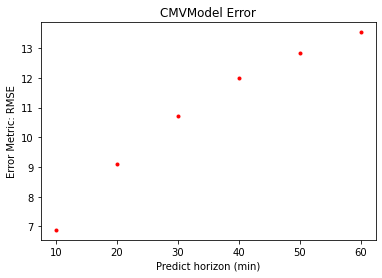

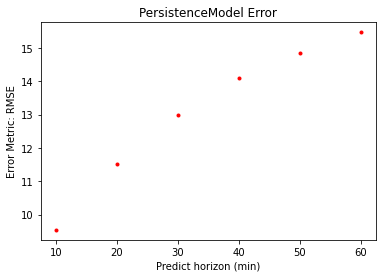

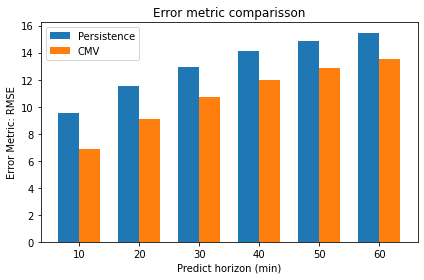

In [4]:
val_mvd = MontevideoFoldersDataset(path = 'data/mvd/val/', in_channel = 2, out_channel=6)
val_loader = DataLoader(val_mvd)

cmv = model.Cmv2()
persistence = model.Persistence()
# blurredCMV = model.Cmv2(kernel_size=(21,21))

print('Predicting CMV')
time.sleep(1)
error_array_cmv = evaluate_model(cmv, val_loader, 6, metric='RMSE')

print()
print('Predicting Persistence')
time.sleep(1)
error_array_p = evaluate_model(persistence, val_loader, 6, metric='RMSE')
# print('Predicting Blurred CMV')
# error_list_bp,error_list_bp_day = main_test(blurredCMV,loader)

# print('CMV predicted ', error_array_cmv.shape[1],  'images for' , error_array_cmv.shape[0], 'images')
# print('Persistence predicted ', error_array_p.shape[1], 'images for' , error_array_p.shape[0],'images')
# print('Blurred Persistence predicted ', error_array_bp.shape[1], 'images for' , error_array_bp.shape[0], 'images')

error_mean_cmv = np.mean(error_array_cmv, axis=0)
error_mean_p = np.mean(error_array_p, axis=0)
print(f'Error_mean_cmv: {error_mean_cmv}')
print(f'Error_mean_p: {error_mean_p}')

visualization.plot_graph(error_mean_cmv, model='CMV')
visualization.plot_graph(error_mean_p, model='Persistence')

visualization.barchart_compare2(
                error_mean_p, 'Persistence',
                error_mean_cmv, 'CMV')

In [5]:
#SETUP
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('using device:', device)

using device: cpu


In [9]:
val_mvd = MontevideoFoldersDataset(path = 'data/mvd/val/' , in_channel = 3, out_channel=6)
val_loader = DataLoader(val_mvd)

load_path = 'checkpoints/model_epoch1.pt'
model_Unet = UNet(n_channels=3, n_classes=1, bilinear=True).to(device)
model_Unet.load_state_dict(torch.load(load_path)["model_state_dict"])
model_Unet.eval()

error_array_Unet = evaluate_model(model_Unet, val_loader, 6, device=device, metric='RMSE')

error_mean_Unet = np.mean(error_mean_Unet, axis=0)
print(f'error_array_Unet: {error_mean_Unet}')


FileNotFoundError: [Errno 2] No such file or directory: 'checkpoints/model_epoch1.pt'

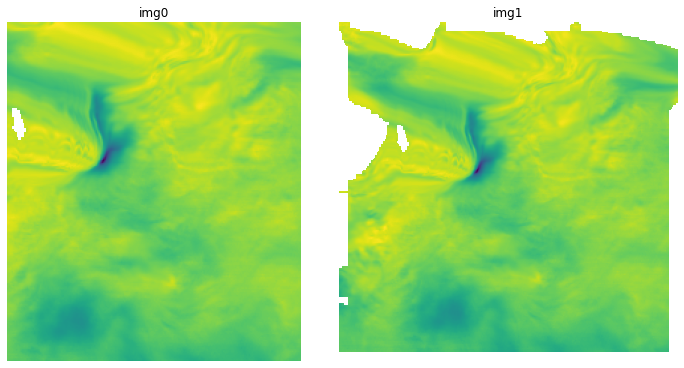

In [7]:
data = np.load('predictions_error.npy')
# visualization.show_image_w_colorbar(data )

data2 = np.load('predictions_error_full.npy')
# visualization.show_image_w_colorbar(data )
visualization.show_image_list([data,data2], 1)